**University:** NOVA Information Management School<br/>
**Program:** Master’s Degree Program in Data Science and Advanced Analytics<br/>
**Academic Year:** 2022/2023

```
============== Students: ==============
Iryna Savchuk (m20211310@novaims.unl.pt)
Cátia Sofia Pereira Parrinha (m20201320@novaims.unl.pt)
Giulia Bovenga (m20221637@novaims.unl.pt)
Hubert Oberhauser (m20220628@novaims.unl.pt)
Leo Allgaier (m20220635@novaims.unl.pt)
=======================================
```

# Import packages

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 

import os
import time
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

# Import Clean Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/gdrive/MyDrive/DL_Project/"
main_folder, training_folder, validation_folder, testing_folder = "datasets/", "train/", "validation/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/gdrive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'datasets.zip', 'datasets.zip')
    # Extract files
    zip_ = zipfile.ZipFile('datasets.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = "/content/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File transfer completed in 3.601 seconds


# List of parameters

In [ ]:
image_size=(128, 128)  
crop_to_aspect_ratio=False 
color_mode='rgb'  
batch_size=64  
label_mode="categorical"  
shuffle=True  
seed=0  

# Create Train, validation and test datasets

In [ ]:
# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_validation = image_dataset_from_directory(path + main_folder + validation_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']


In [ ]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])  # [Batch Size, H, W; C], first image, the first two pixels , of the very first channel
print("\nSample of y_train:", batch_y_train[0:5])  # the first 5 values form the vector
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))  # reflects the balance of our target

(64, 128, 128, 3) (64, 3)

Sample of x_train: tf.Tensor(
[[ 99.26709   99.308105]
 [107.84375  138.55054 ]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)
Sample average of y_train: tf.Tensor(0.33333334, shape=(), dtype=float32)


# Augmentation

In [ ]:
augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.2), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomContrast(factor=0.3),
                           layers.RandomBrightness(factor=0.3),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="my_augmentation_pipeline")
# maybe we can explore different factors

In [ ]:
def show_augmented_sample_batch(batch_x, augmentation_pipe, trials=4, fig_size=(10, 6)):
    # Plot the images
    _, axs = plt.subplots(len(batch_x), trials + 1, figsize=(10, 6), layout='constrained')
    for i, img in enumerate(batch_x):
        axs[i, 0].imshow(tf.cast(img, tf.int32))
        axs[i, 0].set_title("Original image", size=8)
        for t in range(trials):
            # Pass through the augmentation pipeline
            augmented_i = augmentation_pipe(img, training=True)
            axs[i, t+1].imshow(tf.cast(augmented_i, tf.int32))
            axs[i, t+1].set_title("Transformed image#{}".format(t), size=8)

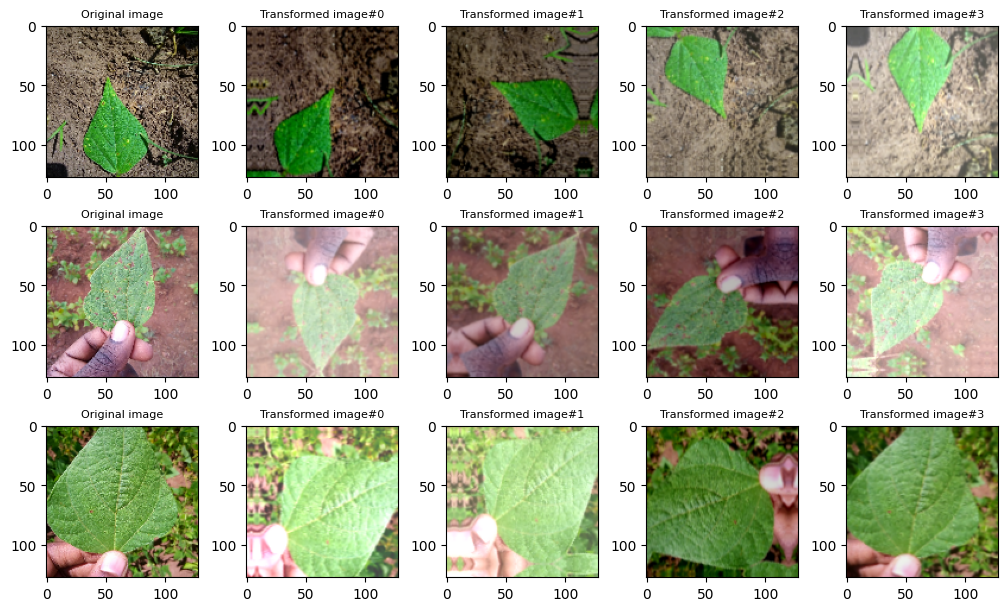

In [ ]:
show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=augmentation)

### Resemble a smaller version of Xception architecture (ResNet)

In [ ]:
 import keras
 
 data_augmentation = keras.Sequential(
            [
               layers.RandomFlip("horizontal"),
               layers.RandomRotation(0.1),
               layers.RandomZoom(0.2),
] )

In [ ]:
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64]:   #, 128, 256, 512]: 
  residual = x
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
  x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation="softmax")(x) 
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 128, 128, 3)  0           ['input_11[0][0]']               
                                                                                                  
 rescaling_10 (Rescaling)       (None, 128, 128, 3)  0           ['sequential_1[1][0]']           
                                                                                                  
 conv2d_67 (Conv2D)             (None, 124, 124, 32  2400        ['rescaling_10[0][0]']    

Epoch 1/80
17/17 [==============================] - 6s 161ms/step - loss: 1.1660 - categorical_accuracy: 0.3424 - AUROC: 0.5067 - val_loss: 1.1103 - val_categorical_accuracy: 0.3083 - val_AUROC: 0.5028
Epoch 2/80
17/17 [==============================] - 4s 171ms/step - loss: 1.1404 - categorical_accuracy: 0.3482 - AUROC: 0.5093 - val_loss: 1.1032 - val_categorical_accuracy: 0.3158 - val_AUROC: 0.5200
Epoch 3/80
17/17 [==============================] - 4s 152ms/step - loss: 1.1201 - categorical_accuracy: 0.3578 - AUROC: 0.5203 - val_loss: 1.0993 - val_categorical_accuracy: 0.3233 - val_AUROC: 0.5236
Epoch 4/80
17/17 [==============================] - 4s 157ms/step - loss: 1.1100 - categorical_accuracy: 0.3482 - AUROC: 0.5272 - val_loss: 1.0974 - val_categorical_accuracy: 0.3233 - val_AUROC: 0.5263
Epoch 5/80
17/17 [==============================] - 4s 173ms/step - loss: 1.1052 - categorical_accuracy: 0.3530 - AUROC: 0.5329 - val_loss: 1.0960 - val_categorical_accuracy: 0.3158 - val_AURO

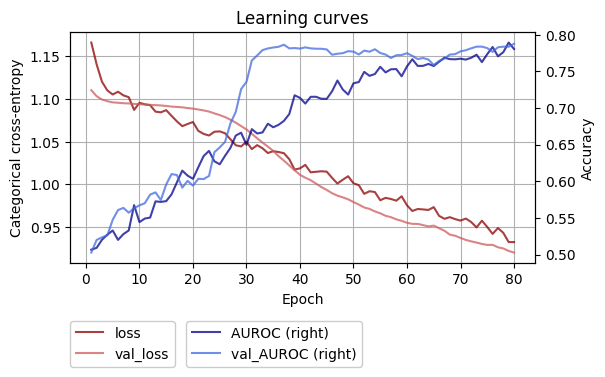

In [ ]:
# Compiles the model for training.
learning_rate = 0.001 

model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.SGD(learning_rate=learning_rate),  
              metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 80
history_0 = model.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history_0.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #  ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()